# **Install & Import Libraries**
Install required libraries

Import essential packages for QA development

In [ ]:
# Install necessary packages (quietly to avoid clutter)
!pip install -q transformers datasets scikit-learn pandas tqdm
!pip install transformers datasets --quiet
#Import core Python & ML libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForQuestionAnswering
from datasets import load_dataset

# Utility libraries
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm #Python library for displaying smart progress bars in loops

# Check GPU
#Dynamically selects between GPU and CPU, so your code works efficiently and flexibly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==

Mount Google drive to load the the trained Model to the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Load & Inspect SQuAD 2.0 Dataset**
Load the dataset from Hugging Face's datasets library

View structure and sample records

Understand how to handle unanswerable questions (which you wisely pointed out earlier)



In [ ]:
#Load the SQuAD 2.0 dataset (train and validation splits)
squad_dataset = load_dataset("squad_v2")

#Convert to DataFrame for easier inspection
df_train = pd.DataFrame(squad_dataset['train'])
df_valid = pd.DataFrame(squad_dataset['validation'])

# View shape and sample records
print("Dataset loaded successfully!")
print(f"Train samples: {len(df_train)}, Validation samples: {len(df_valid)}")
display(df_train.head(2))  # Display first 2 records for clarity
print(df_train.info())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

Dataset loaded successfully!
Train samples: 130319, Validation samples: 11873


,id,title,context,question,answers
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'text': ['in the late 1990s'], 'answer_start'..."
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'text': ['singing and dancing'], 'answer_star..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130319 entries, 0 to 130318
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        130319 non-null  object
 1   title     130319 non-null  object
 2   context   130319 non-null  object
 3   question  130319 non-null  object
 4   answers   130319 non-null  object
dtypes: object(5)
memory usage: 5.0+ MB
None


# **Data Preprocessing for SQuAD 2.0**
Extract the clean answer text (or "No answer" if empty)

Set answer start and end positions (in character indices)

Create the is_impossible flag

Prepare these fields as new columns in the DataFrame

In [ ]:
#Step 1: Define a function to extract clean fields
def preprocess_squad_df(df):
    clean_answers = []
    start_positions = []
    end_positions = []
    impossible_flags = []

    for idx, row in df.iterrows():
        answers = row['answers']

        if answers['text']:
            clean_answer = answers['text'][0]
            start = answers['answer_start'][0]
            end = start + len(clean_answer)
            is_impossible = False
        else:
            clean_answer = "No answer"
            start = 0
            end = 0
            is_impossible = True

        clean_answers.append(clean_answer)
        start_positions.append(start)
        end_positions.append(end)
        impossible_flags.append(is_impossible)

    df['clean_answer'] = clean_answers
    df['answer_start'] = start_positions
    df['answer_end'] = end_positions
    df['is_impossible'] = impossible_flags

    return df

'''# Step 2: Apply to both train and validation datasets
df_train = pd.DataFrame(squad_dataset['train'])
df_valid = pd.DataFrame(squad_dataset['validation'])'''

df_train = preprocess_squad_df(df_train)
df_valid = preprocess_squad_df(df_valid)

#  Step 3: Inspect the new structure
df_train[['context','question', 'clean_answer', 'answer_start', 'answer_end', 'is_impossible']].head(10)


,context,question,clean_answer,answer_start,answer_end,is_impossible
0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s,269,286,False
1,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing,207,226,False
2,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003,526,530,False
3,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas",166,180,False
4,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s,276,286,False
5,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what R&B group was she the lead singer?,Destiny's Child,320,335,False
6,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What album made her a worldwide known artist?,Dangerously in Love,505,524,False
7,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,Who managed the Destiny's Child group?,Mathew Knowles,360,374,False
8,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyoncé rise to fame?,late 1990s,276,286,False
9,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What role did Beyoncé have in Destiny's Child?,lead singer,290,301,False


# **Exploratory Data Analysis (EDA)**
Answerable vs. Unanswerable Distribution

Sequence Length Stats (Max, 95th Percentile

Visuals:

Question length distribution

Context word count distribution

Questions per article title

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

<ipython-input-4-91b1de732ba0>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=answerable_counts.index.map({True: 'Answerable', False: 'Unanswerable'}),


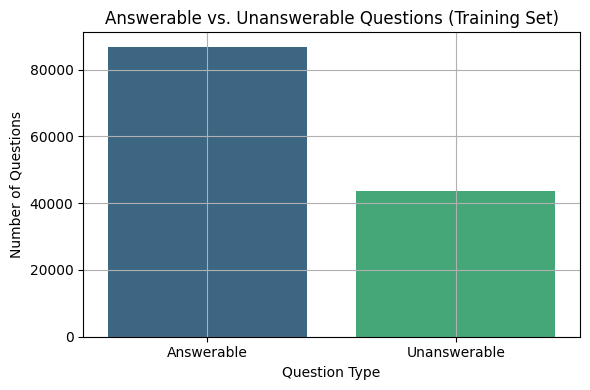

 Answerable distribution:
answerable
True     86821
False    43498
Name: count, dtype: int64


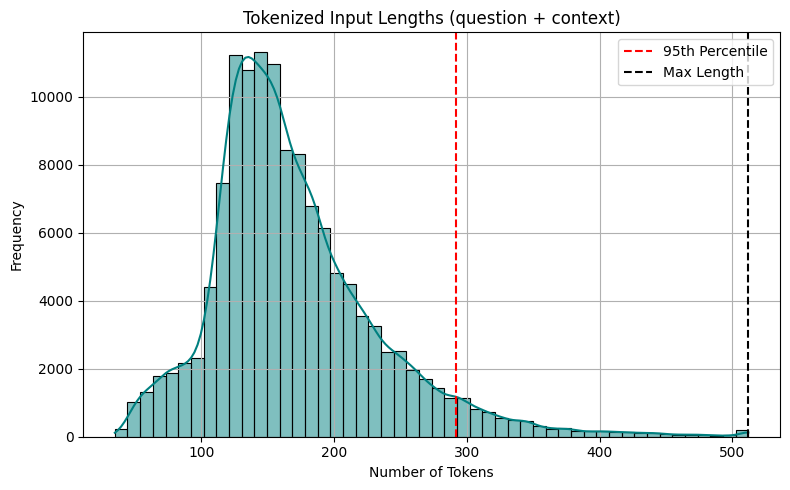

Max input length: 512
 95th percentile length: 292


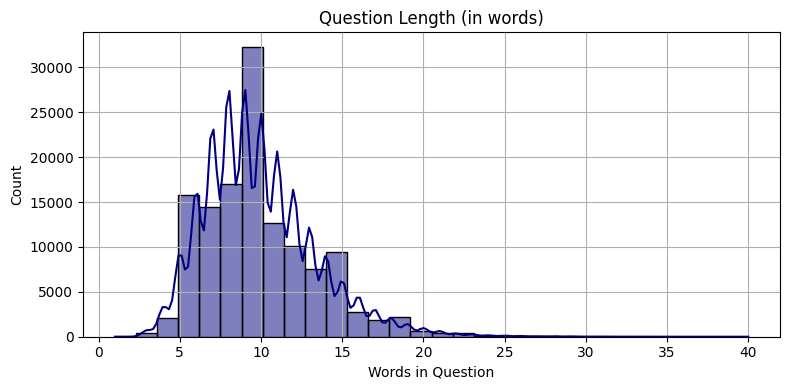

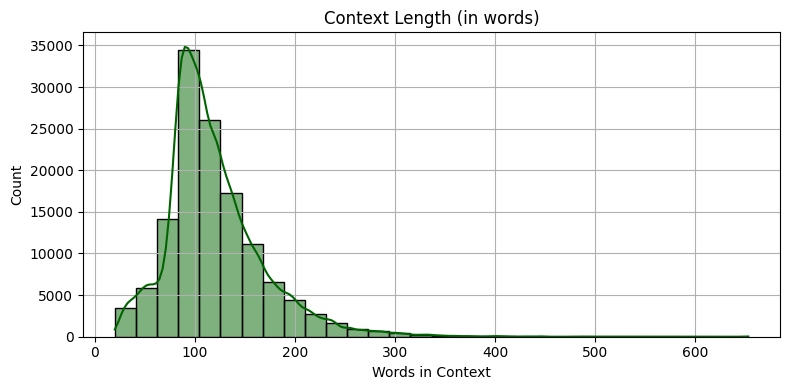

<ipython-input-4-91b1de732ba0>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=title_counts.index, x=title_counts.values, palette="crest")


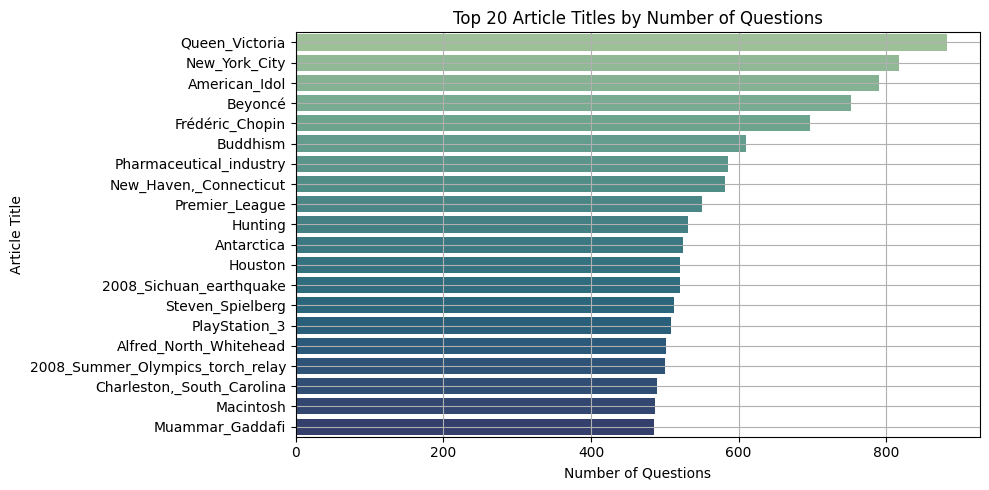

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizerFast

# Use Fast tokenizer for accurate token alignment
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# =====================
# 2B.1 - Answerable vs. Unanswerable
# =====================
df_train['answerable'] = ~df_train['is_impossible']
answerable_counts = df_train['answerable'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=answerable_counts.index.map({True: 'Answerable', False: 'Unanswerable'}),
            y=answerable_counts.values, palette="viridis")
plt.title("Answerable vs. Unanswerable Questions (Training Set)")
plt.ylabel("Number of Questions")
plt.xlabel("Question Type")
plt.grid(True)
plt.tight_layout()
plt.show()

print(" Answerable distribution:")
print(answerable_counts)

# =====================
#  2B.2 - Sequence Length Distribution
# =====================
# Compute input lengths after tokenizing (question + context)
def compute_input_length(row):
    encoded = tokenizer(
        row['question'], row['context'],
        truncation=True, max_length=512, padding=False,
        return_tensors=None
    )
    return len(encoded['input_ids'])

df_train['input_length'] = df_train.apply(compute_input_length, axis=1)

# Plot histogram of input lengths
plt.figure(figsize=(8, 5))
sns.histplot(df_train['input_length'], bins=50, kde=True, color='teal')
plt.axvline(df_train['input_length'].quantile(0.95), color='red', linestyle='--', label='95th Percentile')
plt.axvline(df_train['input_length'].max(), color='black', linestyle='--', label='Max Length')
plt.title("Tokenized Input Lengths (question + context)")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

print("Max input length:", df_train['input_length'].max())
print(" 95th percentile length:", int(df_train['input_length'].quantile(0.95)))

# =====================
#  2B.3 - Optional Visuals
# =====================

# (a) Question length
df_train['question_length'] = df_train['question'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 4))
sns.histplot(df_train['question_length'], bins=30, kde=True, color='navy')
plt.title("Question Length (in words)")
plt.xlabel("Words in Question")
plt.tight_layout()
plt.grid(True)
plt.show()

# (b) Context length
df_train['context_length'] = df_train['context'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 4))
sns.histplot(df_train['context_length'], bins=30, kde=True, color='darkgreen')
plt.title("Context Length (in words)")
plt.xlabel("Words in Context")
plt.tight_layout()
plt.grid(True)
plt.show()

# (c) Questions per Article Title
title_counts = df_train['title'].value_counts().head(20)
plt.figure(figsize=(10, 5))
sns.barplot(y=title_counts.index, x=title_counts.values, palette="crest")
plt.title("Top 20 Article Titles by Number of Questions")
plt.xlabel("Number of Questions")
plt.ylabel("Article Title")
plt.tight_layout()
plt.grid(True)
plt.show()


# **Split df_train into two sets**
df_train_final → 80% of original training (used for training)

df_val_final → 20% of original training (used for validation during training)

df_valid → untouched original validation set from SQuAD (used only for final evaluation)




In [ ]:
from sklearn.model_selection import train_test_split

# ⚙️ 80/20 Split of original training set
df_train_final, df_val_final = train_test_split(
    df_train, test_size=0.2, random_state=42, stratify=df_train["is_impossible"]
)

print(f"Training samples: {len(df_train_final)}")
print(f" Validation samples: {len(df_val_final)}")
print(f"External Test samples (SQuAD val): {len(df_valid)}")


Training samples: 104255
 Validation samples: 26064
📌External Test samples (SQuAD val): 11873


# **Tokenize and Align QA Data**
Tokenize each (question, context) pair using BertTokenizerFast

Convert answer_start (character index) to token-level indices

Handle special cases (unanswerable questions with "No answer")

In [ ]:
from transformers import BertTokenizerFast

# Load fast tokenizer (already done before, but repeating just in case)
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Function to tokenize and align start/end positions
def tokenize_and_align(df, tokenizer, max_length=384):
    input_ids = []
    attention_masks = []
    start_positions = []
    end_positions = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Tokenizing"):
        question = row['question']
        context = row['context']
        answer_text = row['clean_answer']
        answer_start_char = row['answer_start']
        answer_end_char = row['answer_end']
        is_impossible = row['is_impossible']

        # Tokenize with offset mapping
        encoding = tokenizer(
            question,
            context,
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_offsets_mapping=True,
            return_tensors="pt"
        )

        offsets = encoding['offset_mapping'][0]
        input_id = encoding['input_ids'][0]
        attention_mask = encoding['attention_mask'][0]

        # Default positions for unanswerable questions
        start_pos = 0
        end_pos = 0

        if not is_impossible:
            # Find the start/end token indices within the context
            for i, (start, end) in enumerate(offsets):
                if start <= answer_start_char < end:
                    start_pos = i
                if start < answer_end_char <= end:
                    end_pos = i
                    break
            # If no match found, fallback to 0
            if start_pos == 0 and end_pos == 0:
                start_pos = 0
                end_pos = 0

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        start_positions.append(start_pos)
        end_positions.append(end_pos)

    return {
        "input_ids": torch.stack(input_ids),
        "attention_mask": torch.stack(attention_masks),
        "start_positions": torch.tensor(start_positions),
        "end_positions": torch.tensor(end_positions)
    }

# Tokenize all three: train (80%), val (20%), and external SQuAD validation
train_encodings = tokenize_and_align(df_train_final, tokenizer)
val_encodings = tokenize_and_align(df_val_final, tokenizer)
valid_encodings = tokenize_and_align(df_valid, tokenizer)

print(" Tokenization complete for all sets.")
# % of rows exeeding max length =384 tokens
print("% of number rows exeding the chosen no max tokens in df_train_final: ",(df_train_final['input_length'] > 384).mean())
print("% of number rows exeding the chosen no max tokens in df_train_val: ",(df_val_final['input_length'] > 384).mean())


Tokenizing:   0%|          | 0/104255 [00:00<?, ?it/s]

Tokenizing:   0%|          | 0/26064 [00:00<?, ?it/s]

Tokenizing:   0%|          | 0/11873 [00:00<?, ?it/s]

 Tokenization complete for all sets.
% of number rows exeding the chosen no max tokens in df_train_final:  0.010426358448036065
% of number rows exeding the chosen no max tokens in df_train_val:  0.010972989564149785


# **Create QADataset and DataLoader**
Wrap train_encodings and valid_encodings in a PyTorch-compatible dataset class

Enable batch loading using DataLoader

Ready the data for use in training and evaluation loops

In [ ]:
from torch.utils.data import Dataset, DataLoader

# Step 1: Custom Dataset class
class QADataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return self.encodings['input_ids'].shape[0]

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'start_positions': self.encodings['start_positions'][idx],
            'end_positions': self.encodings['end_positions'][idx]
        }

# Step 2: Wrap Encodings into DataLoaders
train_dataset = QADataset(train_encodings)
val_dataset   = QADataset(val_encodings)
valid_dataset = QADataset(valid_encodings)

#  Step 3: Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

#  Step 4: Sanity Check
print(" DataLoaders created:")
print(f" train_loader → {len(train_loader)} batches")
print(f" val_loader   → {len(val_loader)} batches")
print(f" valid_loader → {len(valid_loader)} batches")

#  Test: Check one sample
sample = train_dataset[0]
print("Sample input_ids shape:", sample['input_ids'].shape)
print("Start token index:", sample['start_positions'])
print("End token index:", sample['end_positions'])


 DataLoaders created:
 train_loader → 6516 batches
 val_loader   → 1629 batches
 valid_loader → 743 batches
Sample input_ids shape: torch.Size([384])
Start token index: tensor(8)
End token index: tensor(12)


# **BERT Model Setup and Optimizer Configuration**
Load a pretrained BERT model for question answering

Move the model to the correct device (GPU/CPU)

Define the loss function and optimizer

In [ ]:
from transformers import BertForQuestionAnswering
from torch.optim import AdamW  #  Fixed import

#  Load BERT QA model
model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")

# Move model to device (GPU if available)
model.to(device)
print(f" Model loaded and moved to: {device}")

#  Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

#  Sanity check
print(f"Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")



Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Model loaded and moved to: cuda
Number of trainable parameters: 108,893,186


# **Final version Training loop **
Feature	Status
 Step-based training loop	Included
 get_linear_schedule_with_warmup	Included
 TQDM progress bar	Included
 Mid-step validation	Included
 EM accuracy + validation loss	Included
 Mixed precision training (AMP)	Included
 Sample prediction logging	Included
 Early stopping	Included
 Live plotting (train vs val loss)	Include



In [ ]:
#  Full Enhanced Training Loop for QA (Colab Ready)
# --------------------------------------------------

import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import get_linear_schedule_with_warmup

#  Full Training Function

def train_with_enhancements(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    total_steps,
    eval_every=1000,
    use_scheduler=True,
    use_early_stopping=True,
    early_stopping_patience=5,
    show_predictions_every=500,
    use_mixed_precision=True
):
    model.to(device)
    model.train()

    scaler = torch.cuda.amp.GradScaler(enabled=use_mixed_precision)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=total_steps // 10,  # 10% warmup
        num_training_steps=total_steps
    ) if use_scheduler else None

    step = 0
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    progress = tqdm(total=total_steps, desc="Training")

    while step < total_steps:
        for batch in train_loader:
            model.train()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            optimizer.zero_grad()

            with torch.cuda.amp.autocast(enabled=use_mixed_precision):
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    start_positions=start_positions,
                    end_positions=end_positions
                )
                loss = outputs.loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            if scheduler:
                scheduler.step()

            train_losses.append(loss.item())
            progress.set_postfix({"Loss": loss.item(), "Step": step})
            progress.update(1)
            step += 1

            #  Validation Check
            if step % eval_every == 0 or step == total_steps:
                val_loss, val_acc = evaluate_on_validation(model, val_loader, device)
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)

                print(f"\n📊 Step {step} — Val Loss: {val_loss:.4f} | EM Accuracy: {val_acc:.2f}%")

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    epochs_no_improve = 0
                    torch.save(model.state_dict(), "best_model.pt")
                else:
                    epochs_no_improve += 1

                if use_early_stopping and epochs_no_improve >= early_stopping_patience:
                    print(" Early stopping triggered.")
                    progress.close()
                    return train_losses, val_losses, val_accuracies

            # 🔬 Sample Prediction
            if step % show_predictions_every == 0:
                try:
                    model.eval()
                    offsets = tokenizer(
                        tokenizer.decode(input_ids[0], skip_special_tokens=True),
                        return_offsets_mapping=True,
                        truncation=True,
                        max_length=384,
                        padding='max_length'
                    )['offset_mapping']

                    sample_context = tokenizer.decode(input_ids[0], skip_special_tokens=True)
                    pred_start = torch.argmax(outputs.start_logits[0])
                    pred_end = torch.argmax(outputs.end_logits[0])

                    if pred_start < len(offsets) and pred_end < len(offsets):
                        start_char = offsets[pred_start][0]
                        end_char = offsets[pred_end][1]
                        pred_answer = sample_context[start_char:end_char].strip()
                    else:
                        pred_answer = "[Invalid span]"

                    print("\n [Sample Prediction]")
                    print(f"Predicted: {pred_answer}")
                except:
                    pass

            if step >= total_steps:
                break

    progress.close()
    return train_losses, val_losses, val_accuracies


#  Evaluation Function

def evaluate_on_validation(model, val_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                start_positions=start_positions,
                end_positions=end_positions
            )

            loss = outputs.loss
            total_loss += loss.item()

            start_preds = torch.argmax(outputs.start_logits, dim=1)
            end_preds = torch.argmax(outputs.end_logits, dim=1)
            correct += ((start_preds == start_positions) & (end_preds == end_positions)).sum().item()
            total += input_ids.size(0)

    avg_loss = total_loss / len(val_loader)
    acc = 100.0 * correct / total
    return avg_loss, acc


# 📈 Plotting Function

def plot_loss(train_losses, val_losses, val_accuracies):
    steps = list(range(1, len(val_losses) + 1))
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss", color='blue')
    plt.plot(np.linspace(0, len(train_losses), len(val_losses)), val_losses, label="Val Loss", color='red')
    plt.title("Loss Curve")
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(steps, val_accuracies, marker='o', linestyle='-', color='green')
    plt.title("Validation EM Accuracy")
    plt.xlabel("Evaluation Steps")
    plt.ylabel("Accuracy (%)")
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# **Training Loop Trigger final version**

In [ ]:
from torch.optim import AdamW  # Import AdamW from torch.optim
from transformers import BertForQuestionAnswering
import os

# Model to device
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

#  Total steps (adjust based on full dataset length)
# Example: assume 500 steps per epoch, run for 5 epochs → 2500 steps
total_steps = 40000
eval_every = 1000          # Validate every 1000 steps
show_predictions_every = 2000  # Print a prediction every 2000 steps

# Train
train_losses, val_losses, val_accuracies = train_with_enhancements(
    model=model,
    train_loader=train_loader,      # built from df_training_final
    val_loader=val_loader,          # built from df_val_final
    optimizer=optimizer,
    device=device,
    total_steps=total_steps,
    eval_every=eval_every,
    use_scheduler=True,
    use_early_stopping=True,
    early_stopping_patience=8,
    show_predictions_every=show_predictions_every,
    use_mixed_precision=True  # True only if using GPU
)

# Save the best model & tokenizer
model_dir = "/content/qa_model_checkpoint"
os.makedirs(model_dir, exist_ok=True)

model.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)

print(f" Model and tokenizer saved to: {model_dir}")


<ipython-input-10-f9c3eb543e0c>:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_mixed_precision)
Training:   0%|          | 0/40000 [00:00<?, ?it/s]<ipython-input-10-f9c3eb543e0c>:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_mixed_precision):
Training:   2%|▎         | 1000/40000 [04:48<3:09:46,  3.43it/s, Loss=3.21, Step=999]


📊 Step 1000 — Val Loss: 2.7794 | EM Accuracy: 25.65%


Training:   5%|▌         | 2000/40000 [19:06<3:06:57,  3.39it/s, Loss=2.05, Step=1999]


📊 Step 2000 — Val Loss: 1.8889 | EM Accuracy: 33.42%

🔎 [Sample Prediction]
Predicted: 


Training:   8%|▊         | 3000/40000 [33:25<3:02:32,  3.38it/s, Loss=2.47, Step=2999]


📊 Step 3000 — Val Loss: 1.7004 | EM Accuracy: 38.06%


Training:  10%|█         | 4000/40000 [47:43<2:57:01,  3.39it/s, Loss=1.5, Step=3999]


📊 Step 4000 — Val Loss: 1.5199 | EM Accuracy: 43.17%

🔎 [Sample Prediction]
Predicted: who was legally black under virginia law at the time? of numerous relationships between male slaveholders, overseers, or master ' s sons and women slaves, the most notable is likely that of president thomas jefferson with his slave sally hemings. as noted in the 2012 collaborative smithsonian - monticello exhibit, slavery at monticello : the paradox of liberty, jefferson, then a widower, took hemings as his concubine for nearly 40 years. they had six children of record ; four hemings children survived into adulthood, and he freed them all, among the very few slaves he freed. two were allowed to " escape " to the north in 1822, and two were granted freedom by his will upon his death in 1826. seven - eighths white by ancestry, all four of his hemings children moved to northern states as adults ; three of the four entered the white community, and all their descendants identified as white. of the descen

Training:  12%|█▎        | 5000/40000 [1:02:06<2:51:44,  3.40it/s, Loss=2.08, Step=4999]


📊 Step 5000 — Val Loss: 1.3752 | EM Accuracy: 50.32%


Training:  15%|█▌        | 6000/40000 [1:16:24<2:46:38,  3.40it/s, Loss=1.26, Step=5999]


📊 Step 6000 — Val Loss: 1.3116 | EM Accuracy: 52.46%

🔎 [Sample Prediction]
Predicted: patriot and coworker for religious freedom,


Training:  18%|█▊        | 7000/40000 [1:30:42<2:41:42,  3.40it/s, Loss=0.75, Step=6999]


📊 Step 7000 — Val Loss: 1.3125 | EM Accuracy: 51.48%


Training:  20%|██        | 8000/40000 [1:44:54<2:36:08,  3.42it/s, Loss=0.975, Step=7999]


📊 Step 8000 — Val Loss: 1.2383 | EM Accuracy: 54.25%

🔎 [Sample Prediction]
Predicted: 


Training:  22%|██▎       | 9000/40000 [1:59:16<2:31:04,  3.42it/s, Loss=1.47, Step=8999]


📊 Step 9000 — Val Loss: 1.1898 | EM Accuracy: 55.44%


Training:  25%|██▌       | 10000/40000 [2:13:34<2:26:38,  3.41it/s, Loss=0.896, Step=9999]


📊 Step 10000 — Val Loss: 1.1579 | EM Accuracy: 56.03%

🔎 [Sample Prediction]
Predicted: religion and


Training:  28%|██▊       | 11000/40000 [2:27:58<2:21:59,  3.40it/s, Loss=0.908, Step=10999]


📊 Step 11000 — Val Loss: 1.1700 | EM Accuracy: 57.26%


Training:  30%|███       | 12000/40000 [2:42:10<2:16:34,  3.42it/s, Loss=1.61, Step=11999]


📊 Step 12000 — Val Loss: 1.1385 | EM Accuracy: 58.22%

🔎 [Sample Prediction]
Predicted: hydrogen / orthohydrogen ratio (


Training:  32%|███▎      | 13000/40000 [2:56:30<2:11:39,  3.42it/s, Loss=1.29, Step=12999]


📊 Step 13000 — Val Loss: 1.1281 | EM Accuracy: 56.90%


Training:  35%|███▌      | 14000/40000 [3:10:52<2:06:13,  3.43it/s, Loss=0.297, Step=13999]


📊 Step 14000 — Val Loss: 1.1703 | EM Accuracy: 58.51%

🔎 [Sample Prediction]
Predicted: 


Training:  38%|███▊      | 15000/40000 [3:25:04<2:01:51,  3.42it/s, Loss=0.66, Step=14999]


📊 Step 15000 — Val Loss: 1.1753 | EM Accuracy: 58.64%


Training:  40%|████      | 16000/40000 [3:39:17<1:56:25,  3.44it/s, Loss=0.576, Step=15999]


📊 Step 16000 — Val Loss: 1.2173 | EM Accuracy: 57.06%

🔎 [Sample Prediction]
Predicted: 


Training:  42%|████▎     | 17000/40000 [3:53:28<1:51:50,  3.43it/s, Loss=0.248, Step=16999]


📊 Step 17000 — Val Loss: 1.1617 | EM Accuracy: 59.20%


Training:  45%|████▌     | 18000/40000 [4:07:40<1:47:12,  3.42it/s, Loss=0.454, Step=17999]


📊 Step 18000 — Val Loss: 1.2125 | EM Accuracy: 57.17%

🔎 [Sample Prediction]
Predicted: groups or


Training:  48%|████▊     | 19000/40000 [4:21:52<1:42:25,  3.42it/s, Loss=0.681, Step=18999]


📊 Step 19000 — Val Loss: 1.1677 | EM Accuracy: 58.31%


Training:  50%|█████     | 20000/40000 [4:36:02<1:37:52,  3.41it/s, Loss=0.659, Step=2e+4]


📊 Step 20000 — Val Loss: 1.2505 | EM Accuracy: 57.22%

🔎 [Sample Prediction]
Predicted: 


Training:  52%|█████▎    | 21000/40000 [4:59:31<4:30:59,  1.17it/s, Loss=0.409, Step=20999]


📊 Step 21000 — Val Loss: 1.2207 | EM Accuracy: 59.88%
🛑 Early stopping triggered.


✅ Model and tokenizer saved to: /content/qa_model_checkpoint


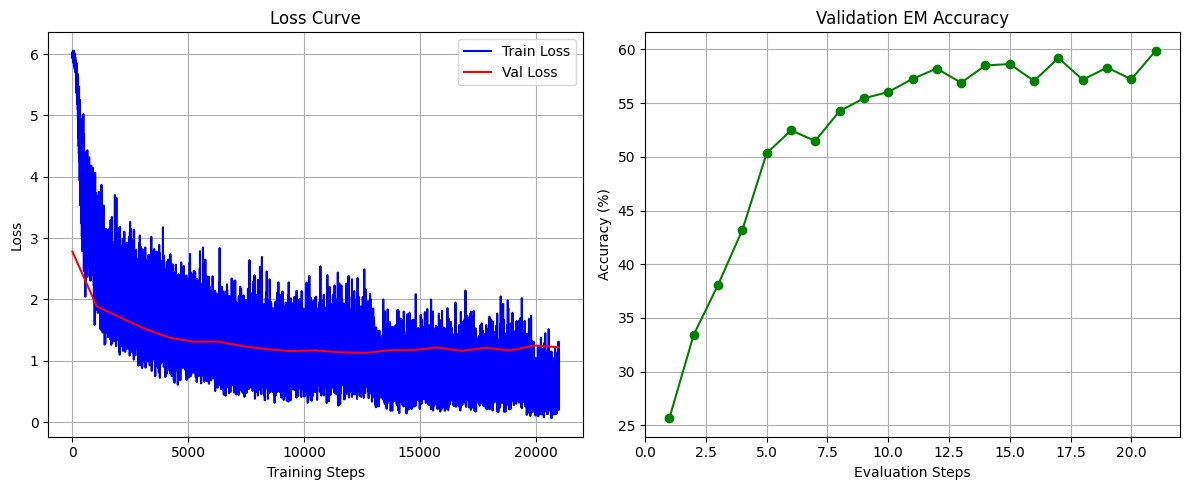

In [ ]:
# 📈 Plot the performance
plot_loss(train_losses, val_losses, val_accuracies)


# **Loading the trained model back to colab **

In [ ]:
import os
from transformers import BertForQuestionAnswering

# 🔧 Set folder path to save locally
model_dir = "/content/qa_model_checkpoint"
os.makedirs(model_dir, exist_ok=True)

# Save model
model.save_pretrained(model_dir)

#  Save tokenizer
tokenizer.save_pretrained(model_dir)

print(f" Model and tokenizer saved to: {model_dir}")


✅ Model and tokenizer saved to: /content/qa_model_checkpoint


In [ ]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Set destination folder in Drive
drive_folder = "/content/drive/My Drive/SQuAD_QA_Mode-V4-sk"
os.makedirs(drive_folder, exist_ok=True)

# Copy saved model and tokenizer to Drive
shutil.copytree(model_dir, drive_folder, dirs_exist_ok=True)

print(f"Model and tokenizer copied to Google Drive at: {drive_folder}")


Mounted at /content/drive
✅ Model and tokenizer copied to Google Drive at: /content/drive/My Drive/SQuAD_QA_Mode-V4


In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch

# Path to your fine-tuned model
model_path = "./qa_model_checkpoint"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForQuestionAnswering.from_pretrained(model_path)
model.eval()


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

# **Download SQuAD v2.0 Validation Set**
 Option 1: Use Python to Download Automatically in Colab
 Downloading SQuADv2. validation dataset directly source

In [ ]:
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O squad2_validation.json


--2025-04-14 15:05:22--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.111.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘squad2_validation.json’

squad2_validation.j 100%[===================>]   4.17M  --.-KB/s    in 0.06s   

2025-04-14 15:05:23 (66.9 MB/s) - ‘squad2_validation.json’ saved [4370528/4370528]



# **Load SQuAD v2.0 Validation Data**

In [ ]:
import json

# Load SQuAD v2.0 validation dataset
with open("squad2_validation.json", "r") as f:
    squad_data = json.load(f)["data"]  # Extract only the "data" section

# Sanity check: print number of articles
print("Number of articles loaded:", len(squad_data))


Number of articles loaded: 35


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device) # Move the model to the selected device

# **Run Predictions with Your BERT Model**
This block loops through every question + context pair in the validation file, performs inference using your BERT model, and stores:

The predicted answer (predictions.json)

The confidence score for unanswerable questions (na_prob.json)

In [ ]:
from tqdm import tqdm
import torch
# Move model to GPU outside the prediction loop
#print("✅ CUDA Available:", torch.cuda.is_available())
#print("💻 Current Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device) # Move the model to the selected device


predictions = {}
na_probs = {}

for article in tqdm(squad_data, desc="Processing Articles"):
    for paragraph in article["paragraphs"]:
        context = paragraph["context"]

        for qa in paragraph["qas"]:
            question = qa["question"]
            qid = qa["id"]

            # Tokenize question-context pair and move to GPU
            inputs = tokenizer(
                question,
                context,
                return_tensors="pt",
                truncation=True,
                max_length=512
            ).to(device)  # Move inputs to the same device as the model

            with torch.no_grad():
                outputs = model(**inputs)
            # --- Improved Span Scoring + No-Answer Logic ---
            max_answer_length = 30
            input_ids = inputs["input_ids"][0]
            start_logits = outputs.start_logits[0]
            end_logits = outputs.end_logits[0]

            # --- Best span selection ---
            best_score = float("-inf")
            best_start = best_end = 0

            for i in range(len(start_logits)):
                for j in range(i, min(i + max_answer_length, len(end_logits))):
                    score = start_logits[i] + end_logits[j]
                    if score > best_score:
                        best_start = i
                        best_end = j
                        best_score = score

            # --- Decode best span ---
            predicted_tokens = input_ids[best_start:best_end + 1]
            answer_text = tokenizer.decode(predicted_tokens, skip_special_tokens=True).strip()

            # --- Logit difference for "no answer" ---
            null_score = (start_logits[0] + end_logits[0]).item()
            logit_diff = null_score - best_score

            # Convert to no-answer probability using sigmoid
            import torch.nn.functional as F
            na_prob = F.sigmoid(torch.tensor(logit_diff)).item()

            # Threshold-based prediction
            threshold = 0.25  # Tune this later during evaluation
            predictions[qid] = "" if na_prob > threshold else answer_text
            na_probs[qid] = round(na_prob, 4)


Processing Articles:   0%|          | 0/35 [00:00<?, ?it/s]<ipython-input-8-156f7d7bbe84>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  na_prob = F.sigmoid(torch.tensor(logit_diff)).item()
Processing Articles: 100%|██████████| 35/35 [46:13<00:00, 79.25s/it]


# **BLOCK 4: Save predictions.json and na_prob.json**
This step writes both dictionaries (predictions, na_probs) into properly formatted .json files.



In [ ]:
from google.colab import files

# Save first (if not already saved)
with open("predictions.json", "w") as f:
    json.dump(predictions, f)

with open("na_prob.json", "w") as f:
    json.dump(na_probs, f)

# Then trigger download
files.download("predictions.json")
files.download("na_prob.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 🔁 Re-run this AFTER the prediction loop finishes

import os
import json

# ✅ Step 1: Mount Google Drive (if not done already)
from google.colab import drive
drive.mount('/content/drive')

# ✅ Step 2: Create save folder
output_folder = "/content/drive/MyDrive/QA_Evaluation_Files_V4/"
os.makedirs(output_folder, exist_ok=True)

# ✅ Step 3: Save predictions and na_prob
with open(output_folder + "predictions.json", "w") as f:
    json.dump(predictions, f)

with open(output_folder + "na_prob.json", "w") as f:
    json.dump(na_probs, f)

print("✅ Files saved to your Google Drive folder at:\n", output_folder)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Files saved to your Google Drive folder at:
 /content/drive/MyDrive/QA_Evaluation_Files_V4/


# **BLOCK 5: Run Official SQuAD v2.0 Evaluation**
This block executes the official script on:

predictions.json

The squad2_validation.json ground-truth file

Your na_prob.json for no-answer thresholding






In [ ]:
!wget https://raw.githubusercontent.com/rajpurkar/SQuAD-explorer/master/evaluate-v2.0.py -O squad_evaluate.py


--2025-04-14 16:08:59--  https://raw.githubusercontent.com/rajpurkar/SQuAD-explorer/master/evaluate-v2.0.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10547 (10K) [text/plain]
Saving to: ‘squad_evaluate.py’

squad_evaluate.py   100%[===================>]  10.30K  --.-KB/s    in 0.001s  

2025-04-14 16:08:59 (15.4 MB/s) - ‘squad_evaluate.py’ saved [10547/10547]



In [ ]:
!python3 squad_evaluate.py \
    squad2_validation.json \
    predictions.json \
    -n na_prob.json \
    -o eval_output.json \
    -t 0.5  # Threshold: If na_prob > 0.5, predict ""


In [ ]:
# Check if the evaluation file was written
import os

if os.path.exists("eval_output.json"):
    with open("eval_output.json", "r") as f:
        results = json.load(f)
    print("✅ Evaluation Results:")
    for key, value in results.items():
        print(f"{key}: {value:.2f}")
else:
    print("⚠️  eval_output.json was not created. Something went wrong.")


✅ Evaluation Results:
exact: 47.28
f1: 52.99
total: 11873.00
HasAns_exact: 60.04
HasAns_f1: 71.47
HasAns_total: 5928.00
NoAns_exact: 34.57
NoAns_f1: 34.57
NoAns_total: 5945.00
best_exact: 58.52
best_exact_thresh: 0.00
best_f1: 62.60
best_f1_thresh: 0.00


# **BLOCK 6: Full In-Notebook Python Evaluation + Visualization**
Let’s start by implementing the core metric logic for:

Exact Match (EM)

F1 Score

Unanswerable Handling

Threshold-based evaluation

PR curves (optional)

In [ ]:
import json
import re
import string
import numpy as np
import collections
import matplotlib.pyplot as plt

# Load SQuAD validation set
with open("squad2_validation.json", "r") as f:
    dataset = json.load(f)["data"]

# Load model predictions
with open("predictions.json", "r") as f:
    preds = json.load(f)

# Load no-answer probabilities
with open("na_prob.json", "r") as f:
    na_probs = json.load(f)


In [ ]:
def normalize_answer(s):
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)
    def white_space_fix(text):
        return ' '.join(text.split())
    def remove_punc(text):
        return ''.join(ch for ch in text if ch not in set(string.punctuation))
    def lower(text):
        return text.lower()
    return white_space_fix(remove_articles(remove_punc(lower(s))))

def get_tokens(s):
    if not s: return []
    return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = num_same / len(pred_toks)
    recall = num_same / len(gold_toks)
    return (2 * precision * recall) / (precision + recall)


In [ ]:
# Map QID to whether the question has a valid answer
def make_qid_to_has_ans(dataset):
    qid_to_has_ans = {}
    for article in dataset:
        for p in article["paragraphs"]:
            for qa in p["qas"]:
                qid = qa["id"]
                qid_to_has_ans[qid] = bool(qa["answers"])
    return qid_to_has_ans

# Get raw scores (no threshold applied)
def get_raw_scores(dataset, preds):
    exact_scores = {}
    f1_scores = {}

    for article in dataset:
        for p in article["paragraphs"]:
            for qa in p["qas"]:
                qid = qa["id"]
                gold_answers = [a["text"] for a in qa["answers"] if a["text"].strip()]

                if not gold_answers:
                    gold_answers = [""]

                if qid not in preds:
                    continue

                pred = preds[qid]
                exact = max(compute_exact(a, pred) for a in gold_answers)
                f1 = max(compute_f1(a, pred) for a in gold_answers)

                exact_scores[qid] = exact
                f1_scores[qid] = f1

    return exact_scores, f1_scores


 **STEP 6.4: Apply Thresholding and Compute Metrics**
We'll define the function to apply your model’s na_prob values and optionally threshold predictions as unanswerable (""), then calculate:

Overall EM and F1

Metrics separately for HasAns and NoAns

Best F1 and EM thresholds

In [ ]:
# Apply threshold to override predictions
def apply_no_ans_threshold(scores, na_probs, qid_to_has_ans, threshold):
    new_scores = {}
    for qid, score in scores.items():
        is_pred_na = na_probs.get(qid, 0.0) > threshold
        if is_pred_na:
            new_scores[qid] = float(not qid_to_has_ans[qid])
        else:
            new_scores[qid] = score
    return new_scores

# Compute overall metrics
def make_eval_dict(exact_scores, f1_scores, qid_to_has_ans, threshold):
    has_ans_qids = [k for k, v in qid_to_has_ans.items() if v]
    no_ans_qids = [k for k, v in qid_to_has_ans.items() if not v]

    exact_thresh = apply_no_ans_threshold(exact_scores, na_probs, qid_to_has_ans, threshold)
    f1_thresh = apply_no_ans_threshold(f1_scores, na_probs, qid_to_has_ans, threshold)

    def average(scores, qids):
        return 100.0 * sum(scores[qid] for qid in qids) / len(qids) if qids else 0.0

    results = {
        "exact": average(exact_thresh, exact_thresh.keys()),
        "f1": average(f1_thresh, f1_thresh.keys()),
        "HasAns_exact": average(exact_thresh, has_ans_qids),
        "HasAns_f1": average(f1_thresh, has_ans_qids),
        "NoAns_exact": average(exact_thresh, no_ans_qids),
        "NoAns_f1": average(f1_thresh, no_ans_qids),
    }
    return results


Run the Evaluation at Default Threshold (e.g., 0.5)

In [ ]:
# Prepare mappings
qid_to_has_ans = make_qid_to_has_ans(dataset)
exact_raw, f1_raw = get_raw_scores(dataset, preds)

# Evaluate with threshold = 0.5
eval_results = make_eval_dict(exact_raw, f1_raw, qid_to_has_ans, threshold= 0.0)

print("✅ Evaluation Results @ threshold :",threshold)
for k, v in eval_results.items():
    print(f"{k}: {v:.2f}")


✅ Evaluation Results @ threshold : 0.25
exact: 58.52
f1: 62.48
HasAns_exact: 47.13
HasAns_f1: 55.07
NoAns_exact: 69.87
NoAns_f1: 69.87


**STEP 6.5: Visualize Metric Scores Across Thresholds**


Loops through thresholds from 0.0 to 1.0

Applies each to your predictions

Plots F1 and Exact Match against thresholds



 Code Block: Generate Threshold Curve and Plot It

In [ ]:
# Sweep over thresholds to find the best EM/F1
thresholds = np.linspace(0, 1, 101)
f1_scores = []
em_scores = []

for t in thresholds:
    result = make_eval_dict(exact_raw, f1_raw, qid_to_has_ans, threshold=t)
    f1_scores.append(result["f1"])
    em_scores.append(result["exact"])

# Find best values
best_f1 = max(zip(thresholds, f1_scores), key=lambda x: x[1])
best_em = max(zip(thresholds, em_scores), key=lambda x: x[1])


Code Block: Plot the Results

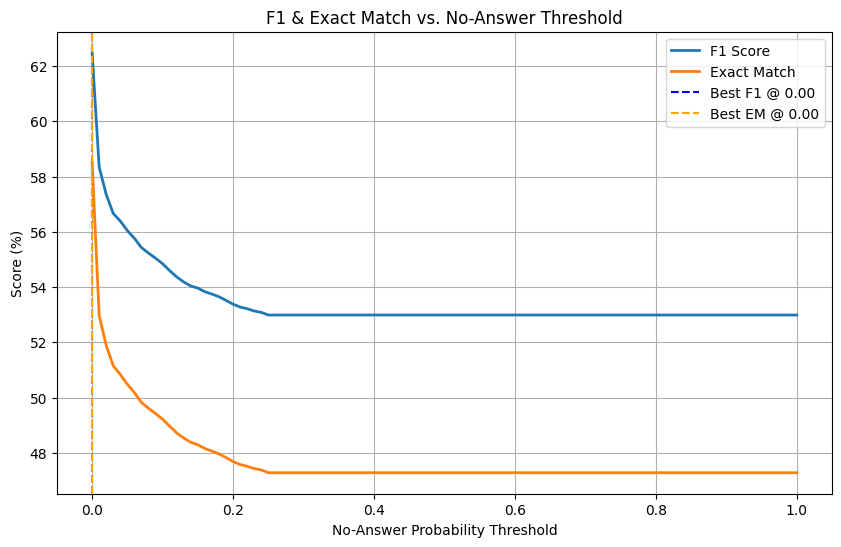

🏆 Best F1 Score: 62.48 at threshold 0.00
🏆 Best EM Score: 58.52 at threshold 0.00


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label="F1 Score", linewidth=2)
plt.plot(thresholds, em_scores, label="Exact Match", linewidth=2)
plt.axvline(best_f1[0], linestyle="--", color="blue", label=f"Best F1 @ {best_f1[0]:.2f}")
plt.axvline(best_em[0], linestyle="--", color="orange", label=f"Best EM @ {best_em[0]:.2f}")
plt.title("F1 & Exact Match vs. No-Answer Threshold")
plt.xlabel("No-Answer Probability Threshold")
plt.ylabel("Score (%)")
plt.legend()
plt.grid(True)
plt.show()

# Also print best scores
print(f"🏆 Best F1 Score: {best_f1[1]:.2f} at threshold {best_f1[0]:.2f}")
print(f"🏆 Best EM Score: {best_em[1]:.2f} at threshold {best_em[0]:.2f}")


# **STEP 7: Visual Error Inspection on Answerable Questions**
This block will:

Filter only HasAns examples from SQuAD

Show actual context, question, ground truth answer, and model prediction

Help identify if there’s a span extraction issue or complete failure



 Code Block: Visual Inspection of Predictions

In [ ]:
import random
from IPython.display import display, Markdown

# Collect a few answerable QIDs
answerable_samples = []

for article in dataset:
    for p in article["paragraphs"]:
        context = p["context"]
        for qa in p["qas"]:
            if qa["answers"]:
                qid = qa["id"]
                if qid in preds:
                    answer = qa["answers"][0]["text"]
                    question = qa["question"]
                    pred = preds[qid]
                    na_prob = na_probs.get(qid, 0.0)

                    answerable_samples.append({
                        "id": qid,
                        "question": question,
                        "context": context,
                        "answer": answer,
                        "prediction": pred,
                        "na_prob": na_prob
                    })

# Show 5 random samples
sampled = random.sample(answerable_samples, 5)

for ex in sampled:
    display(Markdown(f"""
### 🔎 Question ID: `{ex['id']}`
**❓ Question**: {ex['question']}

**📌 Ground Truth Answer**: `{ex['answer']}`
**🤖 Model Prediction**: `{ex['prediction']}`
**📉 No-Answer Prob**: `{ex['na_prob']}`

**🧠 Context Snippet**:
`...{ex['context'][0:400]}...`
"""))



### 🔎 Question ID: `572a03a06aef0514001551ad`
**❓ Question**: How long may the Amazon rainforest be threatened, according to some computer models?

**📌 Ground Truth Answer**: `though the 21st century`
**🤖 Model Prediction**: `21st century`
**📉 No-Answer Prob**: `0.0`

**🧠 Context Snippet**:
`...One computer model of future climate change caused by greenhouse gas emissions shows that the Amazon rainforest could become unsustainable under conditions of severely reduced rainfall and increased temperatures, leading to an almost complete loss of rainforest cover in the basin by 2100. However, simulations of Amazon basin climate change across many different models are not consistent in their e...`



### 🔎 Question ID: `57097051ed30961900e84135`
**❓ Question**: Who did BSkyB compete with initially?

**📌 Ground Truth Answer**: `ONdigital`
**🤖 Model Prediction**: `ondigital ( later itv digital )`
**📉 No-Answer Prob**: `0.0`

**🧠 Context Snippet**:
`...BSkyB's digital service was officially launched on 1 October 1998 under the name Sky Digital, although small-scale tests were carried out before then. At this time the use of the Sky Digital brand made an important distinction between the new service and Sky's analogue services. Key selling points were the improvement in picture and sound quality, increased number of channels and an interactive se...`



### 🔎 Question ID: `570d50a5fed7b91900d45e7d`
**❓ Question**: How much did the gross agricultural product increase from 2003-04?

**📌 Ground Truth Answer**: `$8.7 billion`
**🤖 Model Prediction**: `17 % to $ 8. 7 billion`
**📉 No-Answer Prob**: `0.0`

**🧠 Context Snippet**:
`...During 2003–04, the gross value of Victorian agricultural production increased by 17% to $8.7 billion. This represented 24% of national agricultural production total gross value. As of 2004, an estimated 32,463 farms occupied around 136,000 square kilometres (52,500 sq mi) of Victorian land. This comprises more than 60% of the state's total land surface. Victorian farms range from small horticultu...`



### 🔎 Question ID: `5728eef92ca10214002daab2`
**❓ Question**: When many people are arrested, what is a common tactic negotiating?

**📌 Ground Truth Answer**: `solidarity tactics`
**🤖 Model Prediction**: `solidarity tactics`
**📉 No-Answer Prob**: `0.0193`

**🧠 Context Snippet**:
`...Sometimes the prosecution proposes a plea bargain to civil disobedients, as in the case of the Camden 28, in which the defendants were offered an opportunity to plead guilty to one misdemeanor count and receive no jail time. In some mass arrest situations, the activists decide to use solidarity tactics to secure the same plea bargain for everyone. But some activists have opted to enter a blind ple...`



### 🔎 Question ID: `56e1aba0e3433e1400423097`
**❓ Question**: What is the most commonplace model utilized in complexity theory?

**📌 Ground Truth Answer**: `the Turing machine`
**🤖 Model Prediction**: `the turing machine`
**📉 No-Answer Prob**: `0.0`

**🧠 Context Snippet**:
`...A Turing machine is a mathematical model of a general computing machine. It is a theoretical device that manipulates symbols contained on a strip of tape. Turing machines are not intended as a practical computing technology, but rather as a thought experiment representing a computing machine—anything from an advanced supercomputer to a mathematician with a pencil and paper. It is believed that if ...`


# **Manual Context + Question Input (Test Mode)**

In [ ]:
def predict_answer_v2(question, context, model, tokenizer, max_length=384, threshold=0.5, max_span_length=30):
    model.eval()
    with torch.no_grad():
        # Tokenize with offset mapping for better span decoding
        inputs = tokenizer(
            question,
            context,
            return_tensors="pt",
            truncation=True,
            max_length=max_length,
            return_offsets_mapping=True,
            padding="max_length"
        )

        offset_mapping = inputs.pop("offset_mapping")[0]  # shape: [seq_len, 2]
        inputs = {k: v.to(device) for k, v in inputs.items()}

        outputs = model(**inputs)
        start_logits = outputs.start_logits[0]
        end_logits = outputs.end_logits[0]
        input_ids = inputs["input_ids"][0]

        # Best span selection
        best_score = float("-inf")
        best_start = best_end = 0

        for i in range(len(start_logits)):
            for j in range(i, min(i + max_span_length, len(end_logits))):
                score = start_logits[i] + end_logits[j]
                if score > best_score:
                    best_start = i
                    best_end = j
                    best_score = score

        # Decode span using offset mapping
        start_char = offset_mapping[best_start][0].item()
        end_char = offset_mapping[best_end][1].item()

        predicted_answer = context[start_char:end_char].strip()

        # Compute no-answer probability using logit difference
        null_score = (start_logits[0] + end_logits[0]).item()
        logit_diff = null_score - best_score
        import torch.nn.functional as F
        na_prob = F.sigmoid(logit_diff.clone().detach()).item() if isinstance(logit_diff, torch.Tensor) else F.sigmoid(torch.tensor(logit_diff)).item()

        # Final decision
        if na_prob > threshold or end_char <= start_char:
            return {
                "answer": "No answer",
                "na_probability": round(na_prob, 4),
                "confidence_score": round(best_score.item() if isinstance(best_score, torch.Tensor) else best_score, 4)

            }
        else:
            return {
                "answer": predicted_answer,
                "na_probability": round(na_prob, 4),
                "confidence_score": round(best_score.item() if isinstance(best_score, torch.Tensor) else best_score, 4)
    }



Example Usage

In [ ]:
context = """This is a retrospective study from 3 patients with 2019 - nCoV infection admitted to Renmin Hospital of Wuhan University, a COVID - 2019 designated hospital in Wuhan, from January 31 to February 6, 2020. All patients were diagnosed and classified based on the Diagnosis and Treatment of New Coronavirus Pneumonia ( 6th edition ) published by the National Health Commission of China4. We recorded the epidemiological history, demographic features, clinical characteristics, symptoms and signs, treatment and clinical outcome in detail. Additionally, we found that the proportion of probiotics was significantly reduced, such as Bifidobacterium, Lactobacillus, and Eubacterium, and the proportion of conditioned pathogenic bacteria was significantly increased, such as Corynebacterium of Actinobacteria and Ruthenibacterium of Firmicutes. Notably, all patients died."""

question = "What is the mortality of ARDS caused by viral infections?"


result = predict_answer_v2(question, context, model, tokenizer)
print(" Answer:", result["answer"])
print(" No-Answer Probability:", result["na_probability"])
print("Span Score:", result["confidence_score"])


🔎 Answer: No answer
📉 No-Answer Probability: 0.5
💯 Span Score: 4.262


In [ ]:
!pip install -q sentence-transformers


In [ ]:
import pandas as pd
import json
from tqdm import tqdm
from google.colab import files
from sentence_transformers import SentenceTransformer, util

# Load semantic similarity model
semantic_model = SentenceTransformer('all-MiniLM-L6-v2')

# Upload file
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Detect file type
if filename.endswith(".json"):
    input_type = "json"
elif filename.endswith(".csv"):
    input_type = "csv"
else:
    raise ValueError("Unsupported file type")

results = []

if input_type == "json":
    with open(filename, "r") as f:
        squad_data = json.load(f)["data"]

    for article in tqdm(squad_data, desc="Processing JSON"):
        for paragraph in article["paragraphs"]:
            context = paragraph["context"]
            for qa in paragraph["qas"]:
                qid = qa["id"]
                question = qa["question"]
                true_answer = qa["answers"][0]["text"] if "answers" in qa and qa["answers"] else ""

                result = predict_answer_v2(question, context, model, tokenizer)

                # Semantic similarity
                sim_score = util.cos_sim(
                    semantic_model.encode(result["answer"], convert_to_tensor=True),
                    semantic_model.encode(true_answer, convert_to_tensor=True)
                ).item()

                # Match type
                if result["answer"].strip().lower() == true_answer.strip().lower():
                    match_type = "Exact"
                elif sim_score > 0.8:
                    match_type = "Semantic"
                else:
                    match_type = "Mismatch"

                results.append({
                    "QID": qid,
                    "Question": question,
                    "Ground Truth": true_answer,
                    "Prediction": result["answer"],
                    "No-Answer Probability": result["na_probability"],
                    "Confidence Score": result["confidence_score"],
                    "Semantic Similarity": round(sim_score, 4),
                    "Match Type": match_type
                })

    output_file = "semantic_predictions_json.csv"

elif input_type == "csv":
    df = pd.read_csv(filename)

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing CSV"):
        question = row["question"]
        context = row["context"]
        true_answer = row.get("answer", "")

        result = predict_answer_v2(question, context, model, tokenizer)

        # Semantic similarity
        sim_score = util.cos_sim(
            semantic_model.encode(result["answer"], convert_to_tensor=True),
            semantic_model.encode(true_answer, convert_to_tensor=True)
        ).item()

        # Match type
        if result["answer"].strip().lower() == true_answer.strip().lower():
            match_type = "Exact"
        elif sim_score > 0.8:
            match_type = "Semantic"
        else:
            match_type = "Mismatch"

        results.append({
            "QID": row.get("id", idx),
            "Question": question,
            "Ground Truth": true_answer,
            "Prediction": result["answer"],
            "No-Answer Probability": result["na_probability"],
            "Confidence Score": result["confidence_score"],
            "Semantic Similarity": round(sim_score, 4),
            "Match Type": match_type
        })

    output_file = "semantic_predictions_csv.csv"

# Save + display
df_out = pd.DataFrame(results)
df_out.to_csv(output_file, index=False)
files.download(output_file)

from IPython.display import display, HTML
print(f" Download Ready: {output_file}")
display(HTML(df_out.head(20).to_html(index=False)))


Saving hoard_squad2.json to hoard_squad2 (1).json


Processing JSON: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Download Ready: semantic_predictions_json.csv


QID,Question,Ground Truth,Prediction,No-Answer Probability,Confidence Score,Semantic Similarity,Match Type
q1,What position did William D. Hoard serve in Wisconsin?,16th governor of Wisconsin,16th governor,0.0000,17.0174,0.8139,Semantic
q2,What nickname was William D. Hoard given?,father of modern dairying,father of modern dairying,0.0000,16.3950,1.0000,Exact
q3,Did William D. Hoard advocate for industrial engineering?,,No answer,0.5000,-2.3474,0.1998,Mismatch
q4,What agency did William D. Hoard create related to food inspection?,Dairy and Food Commission,Dairy and Food Commission,0.0000,17.8883,1.0000,Exact
q5,Did William D. Hoard support German language education?,,"November 22, 1918) was an American politician, newspaper publisher, and agriculture advocate who served as the 16th governor of Wisconsin from 1889 to 1891.",0.0071,-0.3266,0.0720,Mismatch


# **Final Visualization Block**

<ipython-input-65-1dd7d1cbf931>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_out, x="Match Type", palette="Set2")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


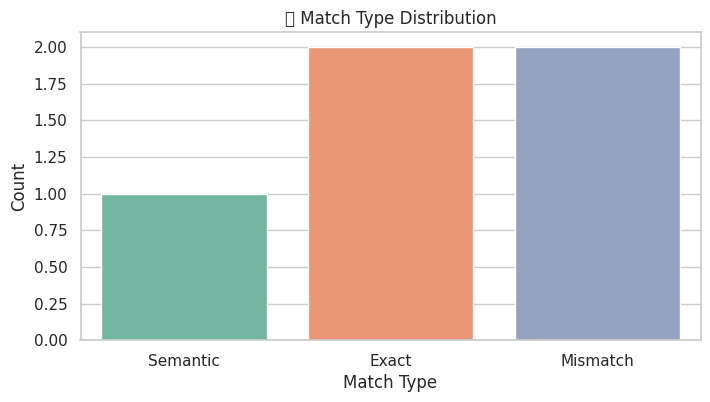

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


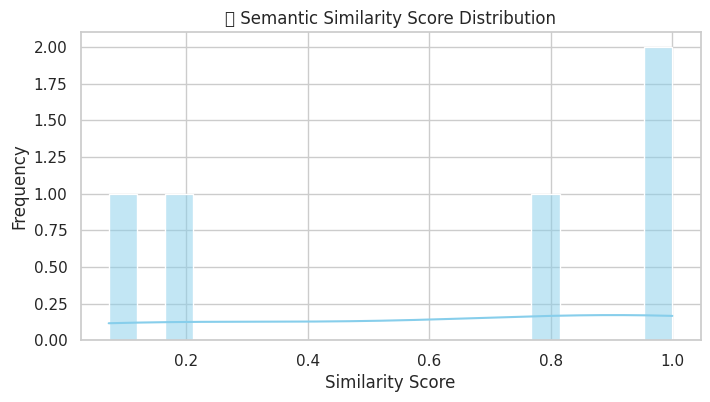

<ipython-input-65-1dd7d1cbf931>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_out, x="Match Type", y="No-Answer Probability", palette="pastel")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


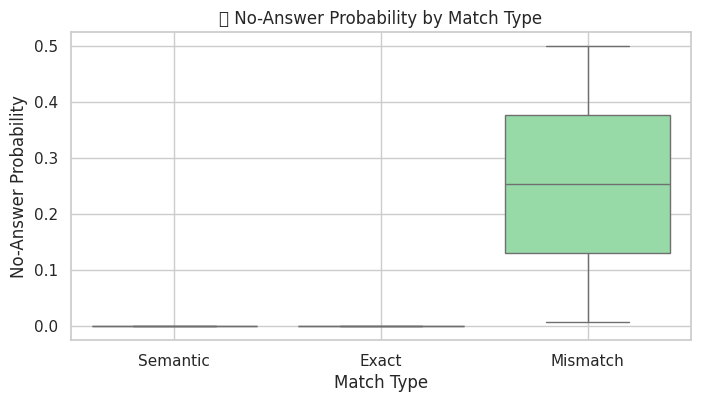

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


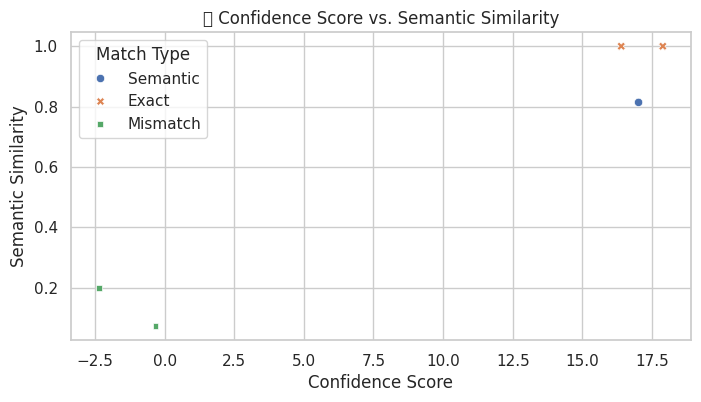

🧾 Match Type Summary:


,Match Type,Count
0,Exact,2
1,Mismatch,2
2,Semantic,1


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Set style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)

# 👁️ 1. Match Type Count
plt.figure()
sns.countplot(data=df_out, x="Match Type", palette="Set2")
plt.title("📊 Match Type Distribution")
plt.ylabel("Count")
plt.xlabel("Match Type")
plt.grid(True, axis='y')
plt.show()

# 👁️ 2. Semantic Similarity Distribution
plt.figure()
sns.histplot(df_out["Semantic Similarity"], bins=20, kde=True, color="skyblue")
plt.title("📈 Semantic Similarity Score Distribution")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 👁️ 3. No-Answer Probability by Match Type
plt.figure()
sns.boxplot(data=df_out, x="Match Type", y="No-Answer Probability", palette="pastel")
plt.title(" No-Answer Probability by Match Type")
plt.xlabel("Match Type")
plt.ylabel("No-Answer Probability")
plt.grid(True)
plt.show()

# 👁️ 4. Confidence Score vs Semantic Similarity
plt.figure()
sns.scatterplot(
    data=df_out,
    x="Confidence Score",
    y="Semantic Similarity",
    hue="Match Type",
    style="Match Type",
    palette="deep"
)
plt.title("📉 Confidence Score vs. Semantic Similarity")
plt.xlabel("Confidence Score")
plt.ylabel("Semantic Similarity")
plt.grid(True)
plt.show()

#  5. Show Full Match Type Summary Table
summary = df_out["Match Type"].value_counts().reset_index()
summary.columns = ["Match Type", "Count"]
print("🧾 Match Type Summary:")
display(summary)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


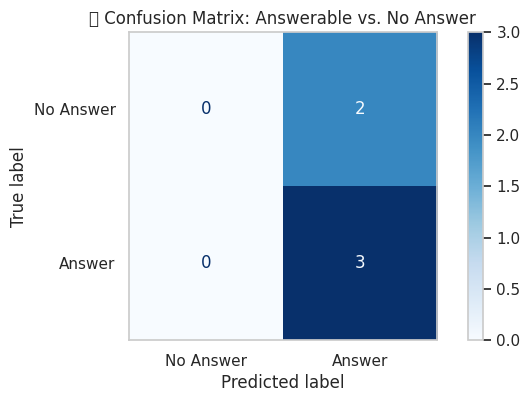

📊 Classification Report (for Answerable Classification)

              precision    recall  f1-score   support

   No Answer       0.00      0.00      0.00         2
      Answer       0.60      1.00      0.75         3

    accuracy                           0.60         5
   macro avg       0.30      0.50      0.38         5
weighted avg       0.36      0.60      0.45         5



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# -----------------------
# 🏷️ Label Preparation
# -----------------------

# True: 1 = has answer, 0 = no answer
df_out["True_Label"] = df_out["Ground Truth"].apply(lambda x: 0 if str(x).strip() == "" else 1)
df_out["Pred_Label"] = df_out["Prediction"].apply(lambda x: 0 if str(x).strip() == "" else 1)

# -----------------------
#  Confusion Matrix
# -----------------------
cm = confusion_matrix(df_out["True_Label"], df_out["Pred_Label"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Answer", "Answer"])
disp.plot(cmap="Blues", values_format='d')
plt.title(" Confusion Matrix: Answerable vs. No Answer")
plt.grid(False)
plt.show()

# -----------------------
#  Classification Report
# -----------------------
print(" Classification Report (for Answerable Classification)\n")
print(classification_report(
    df_out["True_Label"],
    df_out["Pred_Label"],
    target_names=["No Answer", "Answer"]
))


**Save to Google Drive**